In [137]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from typing import TypedDict
from dotenv import load_dotenv
import requests

In [138]:
load_dotenv()

True

In [139]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-pro")

E0000 00:00:1759607132.758316 4888598 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [140]:
class ClassesSchema(BaseModel):
    classes: list[str] = Field(..., description="Category of the query from the following - book_study_room, order_food, get_events, find_campus_service, reserve_parking, check_bus_schedule, book_cab, find_bike_rack, set_reminder, get_weather")

In [141]:
structured_model = model.with_structured_output(ClassesSchema)

In [142]:
class StudentLifeState(TypedDict):
    query: str
    classes: list[str]
    api_results: dict[str, str]
    response: str

In [143]:
def identify_task(state: StudentLifeState) -> StudentLifeState:
    classes_identified = structured_model.invoke(
        f"Identify the category of the following student life related query and the APIs to be called to get information. Query: {state['query']}"
    )
    return {
        "classes": classes_identified.classes
    }

In [144]:
def call_apis(state: StudentLifeState) -> StudentLifeState:
    results = {}
    for api in state["classes"]:
        # Mock API call
        res = requests.get(f"http://localhost:8000/{api}").json()
        results[api] = res
    return {
        "api_results": results
    }


In [145]:
def generate_response(state: StudentLifeState) -> StudentLifeState:
    prompt = f"""
    You are an intelligent assistant. A user asked the following query:

    {state['query']}

    You have received API results for these classes: {state['classes']}

    API Results:
    {state['api_results']}

    Please answer the user's query using the information from the API results. 
    - If the api result asks for weather prediction, then predict the weather based on the location.
    - If multiple classes have relevant data, integrate it into a coherent answer.
    - If no relevant information is found, politely indicate that you cannot find an answer.
    - Keep the response concise and informative.
    """

    reply = model.invoke(prompt)
    state["response"] = reply.content
    return state


In [146]:
graph = StateGraph(StudentLifeState)

In [147]:
graph.add_node("identify_task", identify_task)
graph.add_node("call_apis", call_apis)
graph.add_node("generate_response", generate_response)

In [148]:
graph.add_edge(START, "identify_task")
graph.add_edge("identify_task", "call_apis")
graph.add_edge("call_apis", "generate_response")
graph.add_edge("generate_response", END)

In [149]:
workflow = graph.compile()

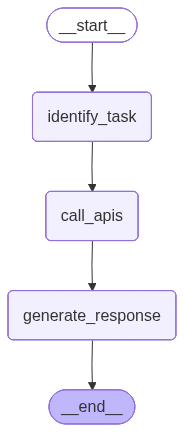

In [150]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [158]:
message = workflow.invoke({"query": "Give me 6th october events"})

In [159]:
message['response']

'On October 6th, 2025, the following events are scheduled:\n\n*   **Chapter 5**: This event runs from 12:00 AM to 1:00 AM.\n*   **Verse One - PRACTICE!**: This practice session, which starts on October 5th, will conclude at 2:00 AM.\n*   **Candidate Meeting 3**: This meeting also starts on October 5th and ends at 12:00 AM.'